# Weight Initialization
In this lesson, you'll learn how to find good initial weights for a neural network. Having good initial weights can place the neural network close to the optimal solution. This allows the neural network to come to the best solution quicker. 


### Dataset
To see how different weights perform, we'll test on the same dataset and neural network. Let's go over the dataset and neural network.

We'll be using the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) to demonstrate the different initial weights. As a reminder, the MNIST dataset contains images of handwritten numbers, 0-9, with normalized input (0.0 - 1.0).  Run the cell below to download and load the MNIST dataset.

In [2]:
# Import necessary packages
from __future__ import print_function
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# Import MNIST data so we have something for our experiments
train_dataset = torchvision.datasets.MNIST(root='.data', train=True, download=True)

In [5]:
def hist_dist(title, values, hist_range=(-4, 4)):
    plt.title(title)
    plt.hist(values, np.linspace(*hist_range, num=len(values)/2))
    plt.show()

## Pytorch Weight Initialization

PyTorch layers are initialized by default in their respective `reset_parameters()` method. For example:

- `nn.Linear`
    - `weight` and `bias`: uniform distribution [-limit, +limit] where `limit` is `1. / sqrt(fan_in)` and `fan_in` is the number of input units in the weight tensor.
- `nn.Conv2D`
    - `weight` and `bias`: uniform distribution [-limit, +limit] where `limit` is `1. / sqrt(fan_in)` and `fan_in` is the number of input units in the weight tensor.

With this implementation, the variance of the layer outputs is equal to `Var(W) = 1 / 3 * sqrt(fan_in)` which isn't the best initialization strategy out there.

Note that PyTorch provides convenience functions for some of the initializations. The input and output shapes are computed using the method `_calculate_fan_in_and_fan_out()` and a `gain()` method scales the standard deviation to suit a particular activation.

```python
# default xavier init
def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu')) 
```

#### Xavier Initialization

This initialization is general-purpose and meant to "work" pretty well for any activation in practice.

```python
# default xavier init
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform(m.weight)
```

You can tailor this initialization to your specific activation by using the `nn.init.calculate_gain(act)` argument.

```python
# default xavier init
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform(m.weight(), gain=nn.init.calculate_gain('relu'))
```

- [arXiv](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

#### He et. al Initialization

This is a similarly derived initialization tailored specifically for ReLU activations since they do not exhibit zero mean.

```python
# he initialization
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal(m.weight, mode='fan_in')
```

For `mode=fan_in`, the variance of the distribution is ensured in the forward pass, while for `mode=fan_out`, it is ensured in the backwards pass.

- [arXiv](https://arxiv.org/abs/1502.01852)

#### SELU Initialization

Again, this initialization is specifically derived for the SELU activation function. The authors use the `fan_in` strategy. They mention that there is no significant difference between sampling from a Gaussian, a truncated Gaussian or a Uniform distribution.

```python
# selu init
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
        nn.init.normal(m.weight, 0, sqrt(1. / fan_in))
    elif isinstance(m, nn.Linear):
        fan_in = m.in_features
        nn.init.normal(m.weight, 0, sqrt(1. / fan_in))
```

- [arXiv](https://arxiv.org/abs/1706.02515)

#### Orthogonal Initialization

Orthogonality is a desirable quality in NN weights in part because it is norm preserving, i.e. it rotates the input matrix, but cannot change its norm (scale/shear). This property is valuable in deep or recurrent networks, where repeated matrix multiplication can result in signals vanishing or exploding.

```python
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.orthogonal(m.weight)
```


In [7]:
def compare_init_weights(dataset, title, weight_init_list, plot_n_batches=100):
    """
    Plot loss and print stats of weights using an example neural network
    """
    colors = ['r', 'b', 'g', 'c', 'y', 'k']
    label_accs = []
    label_loss = []

    assert len(weight_init_list) <= len(colors), 'Too many inital weights to plot'

    for i, (weights, label) in enumerate(weight_init_list):
        loss, val_acc = _get_loss_acc(dataset, weights)

        plt.plot(loss[:plot_n_batches], colors[i], label=label)
        label_accs.append((label, val_acc))
        label_loss.append((label, loss[-1]))

    plt.title(title)
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    print('After 858 Batches (2 Epochs):')
    print('Validation Accuracy')
    for label, val_acc in label_accs:
        print('  {:7.3f}% -- {}'.format(val_acc*100, label))
    print('Loss')
    for label, loss in label_loss:
        print('  {:7.3f}  -- {}'.format(loss, label))

For the neural network, we'll test on a 3 layer neural network with ReLU activations and an Adam optimizer.  The lessons you learn apply to other neural networks, including different activations and optimizers.

## Initialize Weights
Let's start looking at some initial weights.
### All Zeros or Ones
If you follow the principle of [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor), you might think setting all the weights to 0 or 1 would be the best solution.  This is not the case.

With every weight the same, all the neurons at each layer are producing the same output.  This makes it hard to decide which weights to adjust.

Let's compare the loss with all ones and all zero weights using `helper.compare_init_weights`.  This function will run two different initial weights on the neural network above for 2 epochs.  It will plot the loss for the first 100 batches and print out stats after the 2 epochs (~860 batches). We plot the first 100 batches to better judge which weights performed better at the start.

Run the cell below to see the difference between weights of all zeros against all ones.

In [ ]:
r = torch.Tensor(1000).uniform_(-3, 3)

hist_dist('Distribution', r)

As you can see the accuracy is close to guessing for both zeros and ones, around 10%.

The neural network is having a hard time determining which weights need to be changed, since the neurons have the same output for each layer.  To avoid neurons with the same output, let's use unique weights.  We can also randomly select these weights to avoid being stuck in a local minimum for each run.

A good solution for getting these random weights is to sample from a uniform distribution.

### Uniform Distribution
A [uniform distribution](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous%29) has the equal probability of picking any number from a set of numbers. We'll be picking from a continous distribution, so the chance of picking the same number is low. We'll use TensorFlow's `tf.random_uniform` function to pick random numbers from a uniform distribution.

>#### [`torch.Tensor.uniform`](https://www.tensorflow.org/api_docs/python/tf/random_uniform)
>Outputs random values from a uniform distribution.

>The generated values follow a uniform distribution in the range [minval, maxval). The lower bound minval is included in the range, while the upper bound maxval is excluded.

>- **shape:** A 1-D integer Tensor or Python array. The shape of the output tensor.
- **minval:** A 0-D Tensor or Python value of type dtype. The lower bound on the range of random values to generate. Defaults to 0.
- **maxval:** A 0-D Tensor or Python value of type dtype. The upper bound on the range of random values to generate. Defaults to 1 if dtype is floating point.
- **dtype:** The type of the output: float32, float64, int32, or int64.
- **seed:** A Python integer. Used to create a random seed for the distribution. See tf.set_random_seed for behavior.
- **name:** A name for the operation (optional).

We can visualize the uniform distribution by using a histogram. Let's map the values from `tf.random_uniform([1000], -3, 3)` to a histogram using the `helper.hist_dist` function. This will be `1000` random float values from `-3` to `3`, excluding the value `3`.

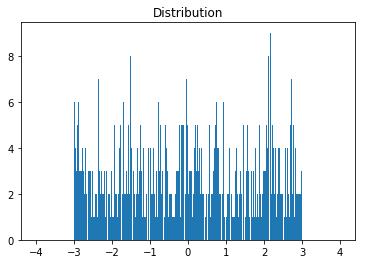

In [7]:
r = torch.Tensor(1000).uniform_(-3, 3)

hist_dist('Distribution', r)

The histogram used 500 buckets for the 1000 values.  Since the chance for any single bucket is the same, there should be around 2 values for each bucket. That's exactly what we see with the histogram.  Some buckets have more and some have less, but they trend around 2.

Now that you understand the `tf.random_uniform` function, let's apply it to some initial weights.

### Baseline


Let's see how well the neural network trains using the default values for `tf.random_uniform`, where `minval=0.0` and `maxval=1.0`.

The loss graph is showing the neural network is learning, which it didn't with all zeros or all ones. We're headed in the right direction.

### General rule for setting weights
The general rule for setting the weights in a neural network is to be close to zero without being too small. A good pracitce is to start your weights in the range of $[-y, y]$ where
$y=1/\sqrt{n}$ ($n$ is the number of inputs to a given neuron).

Let's see if this holds true, let's first center our range over zero.  This will give us the range [-1, 1).

### Too small
Let's compare [-0.1, 0.1), [-0.01, 0.01), and [-0.001, 0.001) to see how small is too small.  We'll also set `plot_n_batches=None` to show all the batches in the plot.

The range we found and $y=1/\sqrt{n}$ are really close.

Since the uniform distribution has the same chance to pick anything in the range, what if we used a distribution that had a higher chance of picking numbers closer to 0.  Let's look at the normal distribution.
### Normal Distribution
Unlike the uniform distribution, the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) has a higher likelihood of picking number close to it's mean. To visualize it, let's plot values from TensorFlow's `torch.Tensor.normal_` function to a histogram.

>[torch.Tensor.normal_](https://www.tensorflow.org/api_docs/python/tf/random_normal)

>Outputs random values from a normal distribution.

>- **shape:** A 1-D integer Tensor or Python array. The shape of the output tensor.
- **mean:** A 0-D Tensor or Python value of type dtype. The mean of the normal distribution.
- **stddev:** A 0-D Tensor or Python value of type dtype. The standard deviation of the normal distribution.
- **dtype:** The type of the output.
- **seed:** A Python integer. Used to create a random seed for the distribution. See tf.set_random_seed for behavior.
- **name:** A name for the operation (optional).

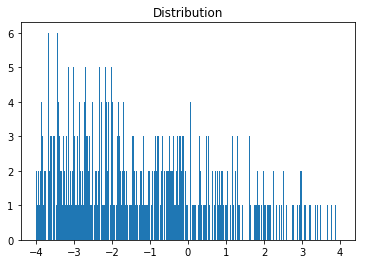

In [9]:
r = torch.Tensor(1000).normal_(-3, 3)

hist_dist('Distribution', r)

The normal distribution gave a slight increasse in accuracy and loss.  Let's move closer to 0 and drop picked numbers that are `x` number of standard deviations away.  This distribution is called [Truncated Normal Distribution](https://en.wikipedia.org/wiki/Truncated_normal_distribution%29).
### Truncated Normal Distribution
>[tf.truncated_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None)](https://www.tensorflow.org/api_docs/python/tf/truncated_normal)

>Outputs random values from a truncated normal distribution.

>The generated values follow a normal distribution with specified mean and standard deviation, except that values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.

>- **shape:** A 1-D integer Tensor or Python array. The shape of the output tensor.
- **mean:** A 0-D Tensor or Python value of type dtype. The mean of the truncated normal distribution.
- **stddev:** A 0-D Tensor or Python value of type dtype. The standard deviation of the truncated normal distribution.
- **dtype:** The type of the output.
- **seed:** A Python integer. Used to create a random seed for the distribution. See tf.set_random_seed for behavior.
- **name:** A name for the operation (optional).

# What is Batch Normalization?<a id='theory'></a>

Batch normalization was introduced in Sergey Ioffe's and Christian Szegedy's 2015 paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). The idea is that, instead of just normalizing the inputs to the network, we normalize the inputs to _layers within_ the network. It's called "batch" normalization because during training, we normalize each layer's inputs by using the mean and variance of the values in the current mini-batch.

Why might this help? Well, we know that normalizing the inputs to a _network_ helps the network learn. But a network is a series of layers, where the output of one layer becomes the input to another. That means we can think of any layer in a neural network as the _first_ layer of a smaller network.

For example, imagine a 3 layer network. Instead of just thinking of it as a single network with inputs, layers, and outputs, think of the output of layer 1 as the input to a two layer network. This two layer network would consist of layers 2 and 3 in our original network. 

Likewise, the output of layer 2 can be thought of as the input to a single layer network, consisting only of layer 3.

When you think of it like that - as a series of neural networks feeding into each other - then it's easy to imagine how normalizing the inputs to each layer would help. It's just like normalizing the inputs to any other neural network, but you're doing it at every layer (sub-network).

Beyond the intuitive reasons, there are good mathematical reasons why it helps the network learn better, too. It helps combat what the authors call _internal covariate shift_. This discussion is best handled [in the paper](https://arxiv.org/pdf/1502.03167.pdf) and in [Deep Learning](http://www.deeplearningbook.org) a book you can read online written by Ian Goodfellow, Yoshua Bengio, and Aaron Courville. Specifically, check out the batch normalization section of [Chapter 8: Optimization for Training Deep Models](http://www.deeplearningbook.org/contents/optimization.html).

### Benefits of Batch Normalization<a id="benefits"></a>

Batch normalization optimizes network training. It has been shown to have several benefits:
1. **Networks train faster** – Each training _iteration_ will actually be slower because of the extra calculations during the forward pass and the additional hyperparameters to train during back propagation. However, it should converge much more quickly, so training should be faster overall. 
2. **Allows higher learning rates** – Gradient descent usually requires small learning rates for the network to converge. And as networks get deeper, their gradients get smaller during back propagation so they require even more iterations. Using batch normalization allows us to use much higher learning rates, which further increases the speed at which networks train. 
3. **Makes weights easier to initialize** – Weight initialization can be difficult, and it's even more difficult when creating deeper networks. Batch normalization seems to allow us to be much less careful about choosing our initial starting weights.  
4. **Makes more activation functions viable** – Some activation functions do not work well in some situations. Sigmoids lose their gradient pretty quickly, which means they can't be used in deep networks. And ReLUs often die out during training, where they stop learning completely, so we need to be careful about the range of values fed into them. Because batch normalization regulates the values going into each activation function, non-linearlities that don't seem to work well in deep networks actually become viable again.  
5. **Simplifies the creation of deeper networks** – Because of the first 4 items listed above, it is easier to build and faster to train deeper neural networks when using batch normalization. And it's been shown that deeper networks generally produce better results, so that's great.
6. **Provides a bit of regularlization** – Batch normalization adds a little noise to your network. In some cases, such as in Inception modules, batch normalization has been shown to work as well as dropout. But in general, consider batch normalization as a bit of extra regularization, possibly allowing you to reduce some of the dropout you might add to a network. 
7. **May give better results overall** – Some tests seem to show batch normalization actually improves the training results. However, it's really an optimization to help train faster, so you shouldn't think of it as a way to make your network better. But since it lets you train networks faster, that means you can iterate over more designs more quickly. It also lets you build deeper networks, which are usually better. So when you factor in everything, you're probably going to end up with better results if you build your networks with batch normalization.

## Batch normalization

Even though we standardized our inputs to have zero mean and unit variance to aid with convergence, our inputs change during training as they go through the different layers and nonlinearities. This is known as internal covariate shirt and it slows down training and requires us to use smaller learning rates. The solution is [batch normalization](https://arxiv.org/abs/1502.03167) (batchnorm) which makes normalization a part of the model's architecture. This allows us to use much higher learning rates and get better performance, faster.

$ BN = \frac{a - \mu_{x}}{\sqrt{\sigma^2_{x} + \epsilon}}  * \gamma + \beta $

where:
* $a$ = activation | $\in \mathbb{R}^{NXH}$ ($N$ is the number of samples, $H$ is the hidden dim)
* $ \mu_{x}$ = mean of each hidden | $\in \mathbb{R}^{1XH}$
* $\sigma^2_{x}$ = variance of each hidden | $\in \mathbb{R}^{1XH}$
* $epsilon$ = noise
* $\gamma$ = scale parameter (learned parameter)
* $\beta$ = shift parameter (learned parameter)

But what does it mean for our activations to have zero mean and unit variance before the nonlinearity operation. It doesn't mean that the entire activation matrix has this property but instead batchnorm is applied on the hidden (num_output_channels in our case) dimension. So each hidden's mean and variance is calculated using all samples across the batch. Also, batchnorm uses the calcualted mean and variance of the activations in the batch during training. However, during test, the sample size could be skewed so the model uses the saved population mean and variance from training. PyTorch's [BatchNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm1d) class takes care of all of this for us automatically.

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/batchnorm.png" width=400>

# Exmaple

This section of the notebook shows you one way to add batch normalization to a neural network built in PyTorch. 

The following cell imports the packages we need in the notebook and loads the MNIST dataset to use in our experiments. However, the `pytorch` package contains all the code you'll actually need for batch normalization.